# Qur'an QA Retrieval Pipeline Starter Notebook

This notebook sketches out the end-to-end pipeline:
1. Data Preparation
2. Sparse (TF-IDF) Indexing & Retrieval
3. Dense (Embeddings + FAISS) Indexing & Retrieval
4. Retriever Fusion
5. Cross-Encoder Re-Ranking
6. No-Answer Detection
7. Answer Selection & Formatting
8. Evaluation & Metrics

---


In [22]:
#!pip install numpy==1.26.4

In [23]:
# 1. Imports and Setup
import os
import pandas as pd
import seaborn as sns
import json
from sklearn.model_selection import train_test_split

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [25]:
# For dense retrieval
import faiss
from sentence_transformers import SentenceTransformer

In [26]:
# For cross-encoder reranking
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# For evaluation
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import numpy as np


Mount Drive

## Evaluation Functions

Recall@K:   
- Definition: Was the correct passage found in the top K?  
- Good for: Checking if the retriever is “finding” the right info.

In [27]:
def recall_at_k(results, gold_map, k):
    hits = []
    for q, golds in gold_map.items():
        topk = [id for id, sim in sorted(results[q], key=lambda x: x[1], reverse=True)]
        hits.append(len(set(topk[:k]) & set(golds)) / len(golds))
    return sum(hits) / len(hits)

Precision@K:   
- Definition: Was the top K of the correct passages?  
- Good for: Checking if the retriever is selecting correct passages.

In [28]:
def precision_at_k(results, gold_map, k):
    """
    Calculates Precision@K for retrieval results.

    Args:
        results (dict): Dictionary of retrieval results, keyed by query,
                        with values as lists of (passage_id, score) tuples.
        gold_map (dict): Dictionary of gold standard answers, keyed by query,
                         with values as sets of correct passage_ids.
        k (int): The number of top retrieved passages to consider.

    Returns:
        float: The average Precision@K across all queries.
    """
    precisions = []
    for q, golds in gold_map.items():
        # Get the top K retrieved passage IDs for the current query
        topk = [id for id, sim in sorted(results[q], key=lambda x: x[1], reverse=True)][:k]

        # Count how many of the top K retrieved passages are in the gold set
        num_relevant_in_topk = len(set(topk) & set(golds))

        # Calculate precision for the current query
        # Avoid division by zero if k is 0 or no results are retrieved
        if k > 0 and len(topk) > 0:
             precision = num_relevant_in_topk / k
        else:
             precision = 0.0 # Precision is 0 if no passages are retrieved in the top K

        precisions.append(precision)

    # Calculate the average precision across all queries
    # Avoid division by zero if gold_map is empty
    if len(precisions) > 0:
        return sum(precisions) / len(precisions)
    else:
        return 0.0 # Return 0 if there are no queries to evaluate

In [29]:
def max_precision_at_k(gold_map, k):
    """
    Calculates the maximum possible Precision@K for retrieval results
    based on the number of gold answers available for each query.

    Args:
        gold_map (dict): Dictionary of gold standard answers, keyed by query,
                         with values as sets of correct passage_ids.
        k (int): The number of top retrieved passages to consider.

    Returns:
        float: The average maximum possible Precision@K across all queries.
    """
    max_precisions = []
    for q, golds in gold_map.items():
        # The maximum possible relevant items in the top K is the minimum of K
        # and the total number of gold answers for the query.
        max_relevant_in_topk = min(k, len(golds))

        # Calculate the maximum possible precision for the current query
        if k > 0:
            max_precision = max_relevant_in_topk / k
        else:
            max_precision = 0.0 # Precision is 0 if k is 0

        max_precisions.append(max_precision)

    # Calculate the average maximum precision across all queries
    if len(max_precisions) > 0:
        return sum(max_precisions) / len(max_precisions)
    else:
        return 0.0 # Return 0 if there are no queries

Mean Reciprocal Rank (MRR).   
- Definition: Average of the reciprocal rank of the first correct result.  
- Good for: Ranking evaluation — high scores = gold is near top.  

In [30]:
def mrr(results, gold_map):
    scores = []
    for q, topk in results.items():
        golds = gold_map[q]
        for i, (pid, _) in enumerate(topk):
            if pid in golds:
                scores.append(1 / (i + 1))
                break
            else:
                scores.append(0)
    return sum(scores) / len(scores)

Rank Info:  
- For individual ranks of every question

In [31]:
def rank_positions(results, gold_map):
    q_ranks = {}
    for q, golds in gold_map.items():
        topk = [id for id, sim in sorted(results[q], key=lambda x: x[1], reverse=True)]
        rank = [topk.index(gold) if gold in topk else -1 for gold in golds ]
        q_ranks[q] = rank
    return q_ranks

## 2. Data Preparation

In [32]:
import re

def normalize_text(text):
    # Lowercase
    text = text.lower()

    # Remove non-alphabetic characters
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)

    # Collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

def normalize_text_arabic(text):
    # Remove non-Arabic alphanumeric characters
    text = re.sub(r'[^\u0600-\u06FF0-9a-zA-Z\s]', '', text)
    return text

In [33]:
# Load Ayatec QA pairs
ayatec = pd.read_csv("../Data/augmented_preprocessed_questions_with_answers_train.csv")  # ensure columns: question, surah_number, ayah_start, ayah_end
ayatec_dev = pd.read_csv("../Data/augmented_preprocessed_questions_with_answers_dev.csv")  # ensure columns: question, surah_number, ayah_start, ayah_end

ayatec = pd.concat([ayatec,ayatec_dev])
# Load Qur'an + Tafseer passages
qbc = pd.read_csv("../Data/qpc_with_quran_translation_and_aljalalyn.csv")  # ensure columns: surah_number, ayah_start, ayah_end, english_passage, tafseer

# Load Arabic Qur'an + Tafseer passages
qbc_arab = pd.read_csv("../Data/Quran_in_arabic_with_aljalalyn_and_almuyassar_tafseer.csv")  # ensure columns: surah_number, ayah_start, ayah_end, english_passage, tafseer

# English
# Merge text fields
qbc['text'] = qbc['english_quran_passage'] + "\n" + qbc['aljalalyn_tafseer']
qbc["text"] = qbc["text"].fillna("")
qbc['norm_text'] = qbc['text'].apply(normalize_text)

# Create unique IDs
qbc['passage_id'] = qbc.apply(lambda r: f"{r.surah_number}:{r.ayah_start}-{r.ayah_end}", axis=1)

# Arabic
# Merge text fields
qbc_arab['text'] = qbc_arab['passage'] + "\n" + qbc_arab['aljalalyn_tafseer']
qbc_arab["text"] = qbc_arab["text"].fillna("")
qbc_arab['norm_text'] = qbc['text'].apply(normalize_text_arabic)

# Create unique IDs
qbc_arab['passage_id'] = qbc_arab.apply(lambda r: f"{r.surah_number}:{r.ayah_start}-{r.ayah_end}", axis=1)

# Ayatec
# Adding augmented answers to questions
ayatec["arabic_Q&A"] = ayatec["arabic"] + "\n" + ayatec["arabic_augment"].fillna("")
ayatec = ayatec.assign(has_answer = lambda x: x["answer"] != "-1")

# Train-test split for Ayatec so that every question is either train or test
# Get the unique questions
unique_questions = ayatec['question_number'].unique()
questions_has_answer = ayatec.groupby("question_number", sort=False)["has_answer"].all()

# Split the unique questions into train and test sets
train_questions, test_questions = train_test_split(
    unique_questions,
    test_size=0.15, # Adjust the test size as needed
    random_state=42, # for reproducibility
    stratify= questions_has_answer
)

# Filter the original ayatec DataFrame to create train_q and test_q based on the split questions
train_q = ayatec[ayatec['question_number'].isin(train_questions)].copy()
test_q = ayatec[ayatec['question_number'].isin(test_questions)].copy()

Group Gold Answers

In [34]:
# Group gold answers
gold_map = ayatec.groupby("question_number")["answer"].apply(list).to_dict()

# question_id to question map
qnumber_map = ayatec.loc[:, ["question_number", "english", "arabic_Q&A"]].drop_duplicates().set_index("question_number").to_dict()

# questiom to question_id map
invert_english_qnumber_map = ayatec.loc[:, ["question_number", "english"]].drop_duplicates().set_index("english").iloc[:,0].to_dict()

Creating dataframe for question level evaluation

Creating dataset for evaluation on question level

In [35]:
eval_df = ayatec.groupby(["question_number","english", "arabic"], sort=False)["answer"].nunique().reset_index(name="count_answers")

In [36]:
eval_df["has_answer"] = ayatec.groupby("english", sort=False)["has_answer"].all().loc[ayatec["english"].unique()].to_list()

## 3. Sparse Retrieval (TF-IDF)

In [37]:
# lemmatize english text
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

qbc['lemm_text'] = qbc['norm_text'].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to /Users/ahmed/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/ahmed/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [38]:
import joblib
# only train if not loaded
if not os.path.exists("../Data/tfidf_matrix.npz") or not os.path.exists("../Data/tfidf_vectorizer.pkl"):
    # Fit once (after loading and processing qbc)
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(qbc['lemm_text'].tolist())
        # save tfidf_matrix and vectorizer at Data for later inference
    tfidf_matrix_path = "../Data/tfidf_matrix.npz"
    tfidf_vectorizer_path = "../Data/tfidf_vectorizer.pkl"
    joblib.dump(tfidf_matrix, tfidf_matrix_path)
    joblib.dump(tfidf_vectorizer, tfidf_vectorizer_path)
else:
    # Load precomputed tfidf_matrix and vectorizer
    tfidf_matrix = joblib.load("../Data/tfidf_matrix.npz")
    tfidf_vectorizer = joblib.load("../Data/tfidf_vectorizer.pkl")





In [39]:
# 3.2 Searching
def tfidf_search(query, top_k=10):
    query = normalize_text(query)
    query = lemmatize_text(query)
    query_vec = tfidf_vectorizer.transform([query])
    scores = cosine_similarity(query_vec, tfidf_matrix).flatten()
    top_idxs = scores.argsort()[::-1][:top_k]
    return [(qbc.iloc[i]['passage_id'], float(scores[i])) for i in top_idxs]


In [40]:
ayatec.head()

,question_number,arabic,english,answer,relevancy,surah_number,ayah_start,ayah_end,quran_passage_arabic,quran_passage_english,arabic_augment,arabic_Q&A,has_answer
0,101,من هم قوم شعيب؟,Who were the people of Shu'ayb?,7:85-93,1,7,85.0,93.0,وإلى مدين أخاهم شعيبا قال يا قوم اعبدوا الله م...,And to the people of Midian [We sent] their br...,أهل مدين.,من هم قوم شعيب؟\n أهل مدين.,True
1,101,من هم قوم شعيب؟,Who were the people of Shu'ayb?,11:84-88,1,11,84.0,88.0,وإلى مدين أخاهم شعيبا قال يا قوم اعبدوا الله م...,And to the people of Midian We sent their brot...,أهل مدين.,من هم قوم شعيب؟\n أهل مدين.,True
2,101,من هم قوم شعيب؟,Who were the people of Shu'ayb?,26:176-191,1,26,176.0,191.0,كذب أصحاب الأيكة المرسلين. إذ قال لهم شعيب ألا...,The people of the Forest[22] rejected the mess...,أهل مدين.,من هم قوم شعيب؟\n أهل مدين.,True
3,101,من هم قوم شعيب؟,Who were the people of Shu'ayb?,29:36-37,1,29,36.0,37.0,وإلى مدين أخاهم شعيبا فقال يا قوم اعبدوا الله ...,To the people of Midian we sent their brother ...,أهل مدين.,من هم قوم شعيب؟\n أهل مدين.,True
4,102,من هم قوم موسى؟,Who were the people of Moses?,7:103-108,1,7,103.0,108.0,ثم بعثنا من بعدهم موسى بآياتنا إلى فرعون وملئه...,Then We sent after them Moses[40] with Our sig...,قوم موسى هم بنو إسرائيل.,من هم قوم موسى؟\n قوم موسى هم بنو إسرائيل.,True


In [41]:
# Run retrieval per unique question
sparse_results = {q: tfidf_search(qnumber_map["english"][q], 50) for q in gold_map}

# Evaluate
print("TF-IDF Recall@50:", recall_at_k(sparse_results, gold_map, 50))
print("TF-IDF Precision@10:", precision_at_k(sparse_results, gold_map, 10))

TF-IDF Recall@50: 0.40357307936013825
TF-IDF Precision@10: 0.0828


In [42]:
eval_df["recall_sparse"] = pd.Series(({q: 1-(ranks.count(-1)/len(ranks)) for q, ranks in rank_positions(sparse_results, gold_map).items()}),name="recall_sparse").reset_index(drop=True)

TODO:
- use BM25 instead of tfidf.
  - BM25 using pysirin was very hard to install on colab or even local
  - BM25 from elastic search needed docker service running (not possible on drive)
- change parameters of tfidf, n-gram, limmtizing words, ...
- Analyze difficult questions
- How about using non Aya/Hadith answer from chatgpt together with the question ?

In [43]:
eval_df["max_sim_sparse"] = [v[0][1] for k, v in sparse_results.items()]

<Axes: xlabel='has_answer', ylabel='max_sim_sparse'>

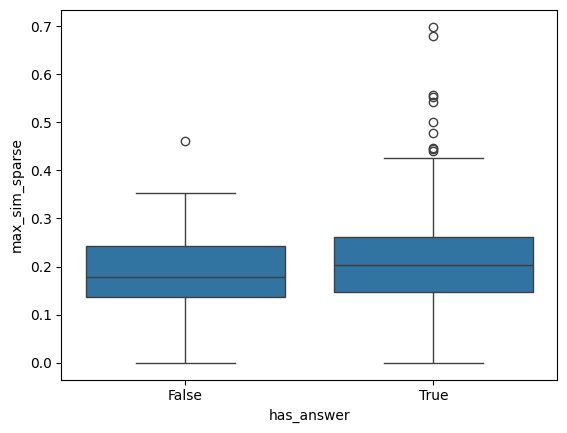

In [44]:
sns.boxplot(eval_df, x="has_answer", y="max_sim_sparse")

Creating dataset for evaluation on answer level

In [45]:
sparse_answer_eval_df = pd.DataFrame([(q,v[0], v[1]) for q, answers in sparse_results.items() for v in answers], columns=["question_number", "answer", "similarity"])

In [46]:
sparse_answer_eval_df = pd.merge(sparse_answer_eval_df,ayatec[["question_number", "has_answer"]].drop_duplicates(), on=["question_number"], how="left")

In [47]:
sparse_answer_eval_df = pd.merge(sparse_answer_eval_df,ayatec[["question_number", "answer", "has_answer"]].rename({"has_answer": "correct_answer"},axis=1), on=["question_number", "answer"], how="left").fillna(False)

/var/folders/79/cr55_gjn2234ndn3x_f5707r0000gn/T/ipykernel_11827/1044630763.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sparse_answer_eval_df = pd.merge(sparse_answer_eval_df,ayatec[["question_number", "answer", "has_answer"]].rename({"has_answer": "correct_answer"},axis=1), on=["question_number", "answer"], how="left").fillna(False)


<Axes: xlabel='has_answer', ylabel='similarity'>

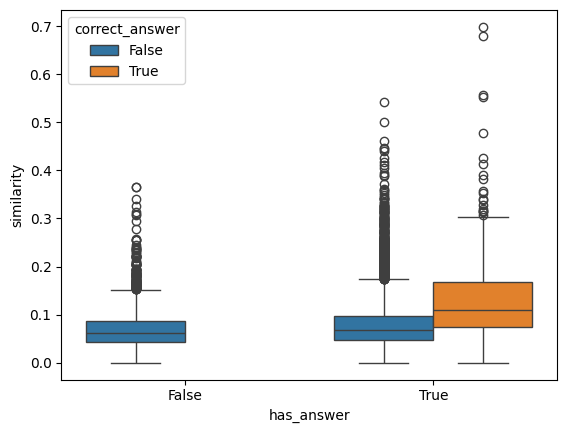

In [48]:
sns.boxplot(sparse_answer_eval_df, x="has_answer", y="similarity", hue="correct_answer")

## 4. Dense Retrieval (Embeddings + FAISS)

In [49]:
# Define the path to save/load embeddings
embeddings_path = "../Data/passage_embeddings_arab.npy"
faiss_index_path = "../Data/faiss_index_arab.faiss"

# 4.1 Encode passages
embed_model_arab = SentenceTransformer('FDSRashid/QulBERT')  # or other embedding

# Check if embeddings and index already exist
if os.path.exists(embeddings_path) and os.path.exists(faiss_index_path):
    print("Loading existing embeddings and FAISS index...")
    passage_embeddings_arab = np.load(embeddings_path)
    d = passage_embeddings_arab.shape[1]
    faiss_index = faiss.read_index(faiss_index_path)
else:
    print("Generating and saving embeddings and FAISS index...")
    passage_embeddings_arab = embed_model_arab.encode(qbc_arab["text"].tolist(), show_progress_bar=True)

    # Save embeddings
    np.save(embeddings_path, passage_embeddings_arab)
    print(f"Embeddings saved to {embeddings_path}")

# 4.2 Build FAISS index
d = passage_embeddings_arab.shape[1]
faiss_index = faiss.IndexFlatIP(d)
faiss.normalize_L2(passage_embeddings_arab)
faiss_index.add(passage_embeddings_arab)

Loading existing embeddings and FAISS index...


In [50]:
# 4.3 Searching
def dense_search_arab(query, top_k=10):
    q_emb = embed_model_arab.encode([query])
    faiss.normalize_L2(q_emb)
    scores, idxs = faiss_index.search(q_emb, top_k)
    results = [(qbc_arab.iloc[i]['passage_id'], float(scores[0][j])) for j,i in enumerate(idxs[0])]
    return results

In [51]:
ayatec

,question_number,arabic,english,answer,relevancy,surah_number,ayah_start,ayah_end,quran_passage_arabic,quran_passage_english,arabic_augment,arabic_Q&A,has_answer
0,101,من هم قوم شعيب؟,Who were the people of Shu'ayb?,7:85-93,1,7,85.0,93.0,وإلى مدين أخاهم شعيبا قال يا قوم اعبدوا الله م...,And to the people of Midian [We sent] their br...,أهل مدين.,من هم قوم شعيب؟\n أهل مدين.,True
1,101,من هم قوم شعيب؟,Who were the people of Shu'ayb?,11:84-88,1,11,84.0,88.0,وإلى مدين أخاهم شعيبا قال يا قوم اعبدوا الله م...,And to the people of Midian We sent their brot...,أهل مدين.,من هم قوم شعيب؟\n أهل مدين.,True
2,101,من هم قوم شعيب؟,Who were the people of Shu'ayb?,26:176-191,1,26,176.0,191.0,كذب أصحاب الأيكة المرسلين. إذ قال لهم شعيب ألا...,The people of the Forest[22] rejected the mess...,أهل مدين.,من هم قوم شعيب؟\n أهل مدين.,True
3,101,من هم قوم شعيب؟,Who were the people of Shu'ayb?,29:36-37,1,29,36.0,37.0,وإلى مدين أخاهم شعيبا فقال يا قوم اعبدوا الله ...,To the people of Midian we sent their brother ...,أهل مدين.,من هم قوم شعيب؟\n أهل مدين.,True
4,102,من هم قوم موسى؟,Who were the people of Moses?,7:103-108,1,7,103.0,108.0,ثم بعثنا من بعدهم موسى بآياتنا إلى فرعون وملئه...,Then We sent after them Moses[40] with Our sig...,قوم موسى هم بنو إسرائيل.,من هم قوم موسى؟\n قوم موسى هم بنو إسرائيل.,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,613,كيف نوفق بين الخوف من الله والرجاء فيه؟,How do we reconcile fear of God with hope in Him?,39:21-26,1,39,21.0,26.0,ألم تر أن الله أنزل من السماء ماء فسلكه ينابيع...,Do you not see that Allah sends down rain from...,قال الله تعالى: {أولئك الذين يدعون يبتغون إلى...,كيف نوفق بين الخوف من الله والرجاء فيه؟\n قال ...,True
294,613,كيف نوفق بين الخوف من الله والرجاء فيه؟,How do we reconcile fear of God with hope in Him?,40:1-4,1,40,1.0,4.0,حم. تنزيل الكتاب من الله العزيز العليم. غافر ا...,Hā Mīm[1]. . The revelation of this Book is fr...,قال الله تعالى: {أولئك الذين يدعون يبتغون إلى...,كيف نوفق بين الخوف من الله والرجاء فيه؟\n قال ...,True
295,613,كيف نوفق بين الخوف من الله والرجاء فيه؟,How do we reconcile fear of God with hope in Him?,41:30-32,1,41,30.0,32.0,إن الذين قالوا ربنا الله ثم استقاموا تتنزل علي...,"Those who say, “Our Lord is Allah,” then remai...",قال الله تعالى: {أولئك الذين يدعون يبتغون إلى...,كيف نوفق بين الخوف من الله والرجاء فيه؟\n قال ...,True
296,613,كيف نوفق بين الخوف من الله والرجاء فيه؟,How do we reconcile fear of God with hope in Him?,50:20-35,1,50,20.0,35.0,ونفخ في الصور ذلك يوم الوعيد. وجاءت كل نفس معه...,And the Trumpet will be blown[12]; that is the...,قال الله تعالى: {أولئك الذين يدعون يبتغون إلى...,كيف نوفق بين الخوف من الله والرجاء فيه؟\n قال ...,True


In [52]:
dense_search_arab("من هم قوم شعيب؟\n  أهل مدين.", top_k=15)

[('7:85-93', 0.6530698537826538),
 ('15:78-79', 0.6475491523742676),
 ('22:42-46', 0.6142697334289551),
 ('29:36-37', 0.5973073244094849),
 ('50:12-15', 0.5958229303359985),
 ('37:133-138', 0.584734320640564),
 ('29:38-40', 0.5570353269577026),
 ('7:65-72', 0.5496866703033447),
 ('29:24-27', 0.5431979298591614),
 ('26:160-175', 0.5390265583992004),
 ('38:12-16', 0.5350059866905212),
 ('25:35-40', 0.5335819125175476),
 ('37:123-132', 0.5199545621871948),
 ('9:69-70', 0.4960579574108124),
 ('46:21-25', 0.49258187413215637)]

In [53]:
# Run retrieval per unique question
dense_results_arab = {q: dense_search_arab(qnumber_map["arabic_Q&A"][q], 50) for q in gold_map}

# Evaluate
print("Dense Recall@20:", recall_at_k(dense_results_arab, gold_map, 50))
print("Dense Precision@10:", precision_at_k(dense_results_arab, gold_map, 10))

Dense Recall@20: 0.43150109254425034
Dense Precision@10: 0.0832


In [54]:
eval_df["recall_dense"] = pd.Series(({q: 1-(ranks.count(-1)/len(ranks)) for q, ranks in rank_positions(dense_results_arab, gold_map).items()}),name="recall_dense").reset_index(drop=True)

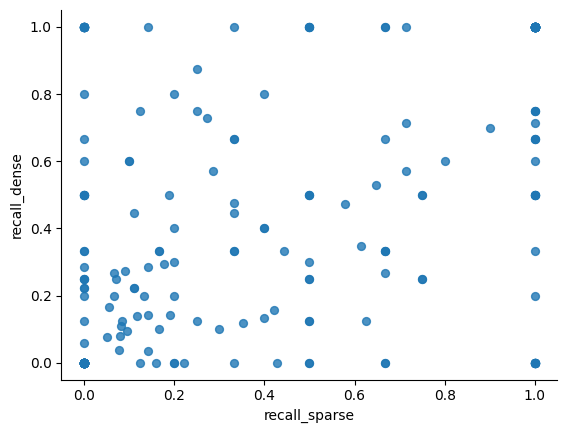

In [55]:
from matplotlib import pyplot as plt
eval_df.plot(kind='scatter', x='recall_sparse', y='recall_dense', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [56]:
eval_df["max_sim_dense"] = [v[0][1] for k, v in dense_results_arab.items()]

<Axes: xlabel='max_sim_dense', ylabel='max_sim_sparse'>

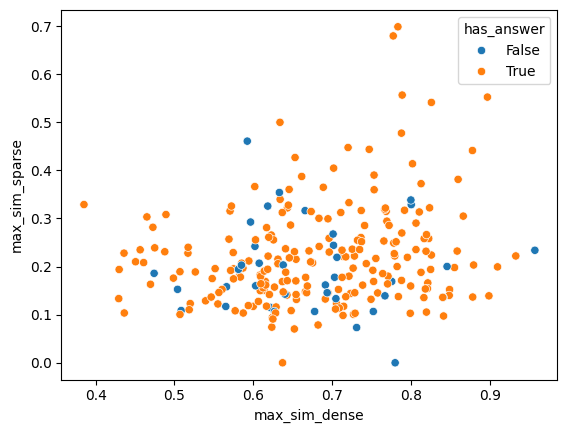

In [57]:
sns.scatterplot(data=eval_df,x= "max_sim_dense", y = "max_sim_sparse", hue= "has_answer")

Creating dataset for evaluation on answer level

In [58]:
dense_answer_eval_df = pd.DataFrame([(q,v[0], v[1]) for q, answers in dense_results_arab.items() for v in answers], columns=["question_number", "answer", "similarity"])

In [59]:
dense_answer_eval_df = pd.merge(dense_answer_eval_df,ayatec[["question_number", "has_answer"]].drop_duplicates(), on=["question_number"], how="left")

In [60]:
dense_answer_eval_df = pd.merge(dense_answer_eval_df,ayatec[["question_number", "answer", "has_answer"]].rename({"has_answer": "correct_answer"},axis=1), on=["question_number", "answer"], how="left").fillna(False)

/var/folders/79/cr55_gjn2234ndn3x_f5707r0000gn/T/ipykernel_11827/1632383901.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dense_answer_eval_df = pd.merge(dense_answer_eval_df,ayatec[["question_number", "answer", "has_answer"]].rename({"has_answer": "correct_answer"},axis=1), on=["question_number", "answer"], how="left").fillna(False)


<Axes: xlabel='has_answer', ylabel='similarity'>

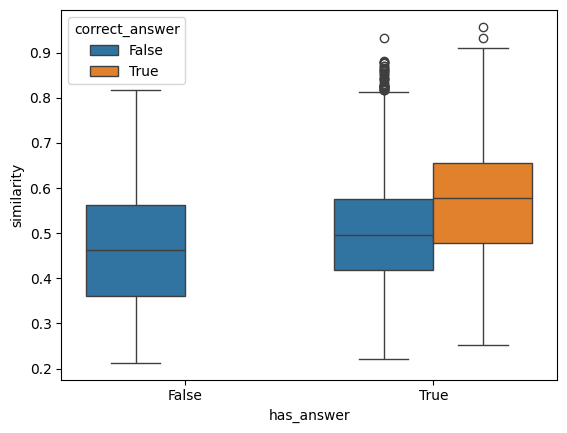

In [61]:
sns.boxplot(dense_answer_eval_df, x="has_answer", y="similarity", hue="correct_answer")

TODO:
- use diffrent embedding model
- Analyze difficult questions

## 5. Retriever Fusion

In [62]:
def hybrid_retrieve(query_e, query_a, k1=10, k2=10, final_k=20):
    sparse = tfidf_search(query_e, k1)
    dense = dense_search_arab(query_a, k2)
    # TODO: normalize scores and merge, then select top final_k
    # Simple placeholder: just concatenate for now
    all_cand = sparse + dense
    # TODO: implement proper fusion
    return all_cand[:final_k]

In [63]:
# Run retrieval per unique question
hyprid_results_arab = {q: hybrid_retrieve(qnumber_map["english"][q], qnumber_map["arabic_Q&A"][q], k1=50, k2=50, final_k=100) for q in gold_map}

# Evaluate
print("hyprid Recall@100:", recall_at_k(hyprid_results_arab, gold_map, 100))
print("hyprid Precision@10:", precision_at_k(hyprid_results_arab, gold_map, 10))

hyprid Recall@100: 0.5634132935944395
hyprid Precision@10: 0.08320000000000002


In [64]:
eval_df["recall_hyprid"] = pd.Series(({q: 1-(ranks.count(-1)/len(ranks)) for q, ranks in rank_positions(hyprid_results_arab, gold_map).items()}),name="recall_hyprid").reset_index(drop=True)

In [65]:
(eval_df["recall_dense"] > eval_df["recall_sparse"]).mean()

np.float64(0.3)

In [66]:
(eval_df["recall_sparse"] > eval_df["recall_dense"]).mean()

np.float64(0.26)

TODO:
- make diffrent merging method than just concat
- Analyse how sparse VS dense performing in question

## 6. Cross-Encoder Re-Ranking

In [67]:
# 6.1 Prepare data for fine-tuning
# Format: question \t passage_text \t label (1 or 0)
# TODO: generate positives and negatives from train_q

# 6.2 Fine-tune cross-encoder
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [68]:
sparse_results_test = {q:pl for q,pl in sparse_results.items() if (test_q["question_number"] == q).any}
dense_results_test = {q:pl for q,pl in dense_results_arab.items() if (test_q["question_number"] == q).any}

In [69]:
sparse_results_train = {q:pl for q,pl in sparse_results.items() if (train_q["question_number"]== q).any()}
dense_results_train = {q:pl for q,pl in dense_results_arab.items() if (train_q["question_number"]== q).any()}

In [80]:
from collections import defaultdict

def prepare_cross_encoder_data(qa_dataframe, sparse_results, dense_results, qbc_dataframe, invert_english_qnumber_map, num_negatives=10):
    """
    Prepares data for fine-tuning a cross-encoder model.

    Args:
        qa_dataframe (pd.DataFrame): DataFrame containing question-answer pairs
                                     with columns 'english' (question) and 'answer' (passage_id).
        sparse_results (dict): Dictionary of sparse retrieval results,
                               keyed by question with a list of (passage_id, score) tuples.
        dense_results (dict): Dictionary of dense retrieval results,
                              keyed by question with a list of (passage_id, score) tuples.
        qbc_dataframe (pd.DataFrame): DataFrame containing passage information
                                      with columns 'passage_id' and 'text'.
        num_negatives (int): The number of negative samples to generate per question.

    Returns:
        list: A list of dictionaries, each containing 'question', 'passage', and 'label'.
    """
    training_data = []

    # Group qa_dataframe by question to get all gold answers for each unique question
    gold_answers_map = defaultdict(list)
    for _, row in qa_dataframe.iterrows():
        gold_answers_map[row['english']].append(row['answer'])

    # Generate positive and negative examples for each unique question
    for question, gold_passage_ids in gold_answers_map.items():
        # Generate positive examples
        for gold_passage_id in gold_passage_ids:
            # Find the corresponding passage text
            passage_row = qbc_dataframe.loc[qbc_dataframe['passage_id'] == gold_passage_id]
            if not passage_row.empty:
                passage_text = passage_row['text'].values[0]
                training_data.append({'question': question, 'passage': passage_text, 'label': 1})
            else:
                print(f"Warning: Gold Passage ID {gold_passage_id} not found in qbc_dataframe for question: {question}.")

        # Generate negative examples from sparse and dense retrieval candidates
        sparse_candidates = [pid for pid, score in sparse_results.get(invert_english_qnumber_map[question], [])]
        dense_candidates = [pid for pid, score in dense_results.get(invert_english_qnumber_map[question], [])]

        # Combine candidates and remove the gold answers
        all_candidates = list(set(sparse_candidates + dense_candidates))
        negative_candidate_ids = [pid for pid in all_candidates if pid not in gold_passage_ids]

        # Randomly sample some negative passages from these candidates
        current_num_negatives = min(num_negatives, len(negative_candidate_ids))
        if current_num_negatives > 0:
            sampled_negative_ids = np.random.choice(negative_candidate_ids, current_num_negatives, replace=False)

            for neg_pid in sampled_negative_ids:
                passage_row = qbc_dataframe.loc[qbc_dataframe['passage_id'] == neg_pid]
                if not passage_row.empty:
                    neg_passage_text = passage_row['text'].values[0]
                    training_data.append({'question': question, 'passage': neg_passage_text, 'label': 0})
                else:
                     print(f"Warning: Negative Passage ID {neg_pid} not found in qbc_dataframe for question: {question}.")
        else :
            print(f"Warning: Negative Passage not found for question: {question}.")


    return training_data

# training data:
training_data = prepare_cross_encoder_data(train_q, sparse_results_train, dense_results_train, qbc, invert_english_qnumber_map, num_negatives=100)

# test data :
test_evaluation_data = prepare_cross_encoder_data(test_q, sparse_results_test, dense_results_test, qbc, invert_english_qnumber_map, num_negatives=100)

In [81]:
from datasets import Dataset

# Function to tokenize the data
def tokenize_function(examples):
    # Tokenize the question and passage pairs
    # The tokenizer expects lists of strings
    return tokenizer(examples['question'], examples['passage'], padding="max_length", truncation=True)

# Convert list of dicts to Hugging Face Dataset objects
train_dataset = Dataset.from_dict({'question': [x['question'] for x in training_data],
                                   'passage': [x['passage'] for x in training_data],
                                   'label': [x['label'] for x in training_data]})

test_dataset = Dataset.from_dict({'question': [x['question'] for x in test_evaluation_data],
                                  'passage': [x['passage'] for x in test_evaluation_data],
                                  'label': [x['label'] for x in test_evaluation_data]})


# Apply the tokenization function to the datasets
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format to PyTorch tensors
tokenized_train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'token_type_ids', 'label'])
tokenized_test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'token_type_ids', 'label'])

Map:   0%|          | 0/20383 [00:00<?, ? examples/s]

Map:   0%|          | 0/3611 [00:00<?, ? examples/s]

1367

In [ ]:
import os
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np # Import numpy
import torch # Import torch

# Path where you want to save your checkpoints (change this to your desired Drive path)
checkpoint_output_dir = "../Model/cross_encoder_checkpoints"

# Ensure the directory exists
os.makedirs(checkpoint_output_dir, exist_ok=True)

# Find the latest checkpoint directory to resume from, if it exists
latest_checkpoint = None
if os.path.exists(checkpoint_output_dir):
    checkpoints = [d for d in os.listdir(checkpoint_output_dir) if os.path.isdir(os.path.join(checkpoint_output_dir, d)) and d.startswith("checkpoint-")]
    if checkpoints:
        # Sort by checkpoint number to find the latest
        checkpoints.sort(key=lambda x: int(x.split('-')[1]))
        latest_checkpoint_path = os.path.join(checkpoint_output_dir, checkpoints[-1])
        print(f"Found latest checkpoint: {latest_checkpoint_path}")
        # When resuming, you pass the *path* to the checkpoint directory
        latest_checkpoint = latest_checkpoint_path
    else:
        print("No checkpoints found, starting training from scratch.")
else:
    print("Checkpoint directory does not exist, starting training from scratch.")


# Define training arguments with saving enabled and evaluation strategy
training_args = TrainingArguments(
    output_dir=checkpoint_output_dir, # Use the checkpoint directory as output
    num_train_epochs=10,             # Total number of training epochs
    per_device_train_batch_size=32,  # Batch size
    warmup_steps=500,                # Warmup steps
    weight_decay=0.01,               # Weight decay
    logging_dir='./logs',            # Logging directory
    logging_steps=10,
    eval_strategy="epoch",        # Evaluate at the end of each epoch
    save_strategy="epoch",           # Save at the end of each epoch
    save_steps=10,                   # Save every 10 epoch
    save_total_limit=2,              # Keep only the 3 most recent checkpoints
    load_best_model_at_end=True, # Load the best model based on evaluation metric
    metric_for_best_model="precision", # Metric to monitor for best model
    # remove_unused_columns=False, # Add if needed to prevent issues with dataset columns
)

# Function to compute metrics (moved here to be in the same cell for clarity)
def compute_metrics(p):
    """Computes accuracy, precision, recall, and f1 for a sequence classification model."""
    preds = np.argmax(p.predictions, axis=1)
    # Assuming binary classification where label 1 is the positive class
    precision = precision_score(p.label_ids, preds, average='binary', zero_division=0)
    recall = recall_score(p.label_ids, preds, average='binary', zero_division=0)
    f1 = f1_score(p.label_ids, preds, average='binary', zero_division=0)
    accuracy = accuracy_score(p.label_ids, preds)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset, # Use tokenized dataset
    eval_dataset=tokenized_test_dataset, # Use tokenized dataset
    compute_metrics=compute_metrics # Add compute_metrics function
)

# Start or resume training
trainer.train(resume_from_checkpoint=latest_checkpoint)

# After training is complete (or resumed), you can save the final model weights separately if desired
# trainer.save_model("/content/drive/MyDrive/IslamicEval/Model/cross_encoder_final_model")

No checkpoints found, starting training from scratch.


/var/folders/79/cr55_gjn2234ndn3x_f5707r0000gn/T/ipykernel_11827/3851025783.py:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  weighted_trainer = WeightedTrainer(
/Users/ahmed/Documents/Academic/Competitions/IslamicEval - Online/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TypeError: compute_loss() got an unexpected keyword argument 'num_items_in_batch'

In [ ]:
# Use class weights in the loss function to address class imbalance
import torch
from transformers import Trainer

# Calculate class weights (example for binary classification)
num_label_0 = sum(train_dataset['label'] == 0)
num_label_1 = sum(train_dataset['label'] == 1)

# Avoid division by zero
if num_label_1 == 0:
    pos_weight = torch.tensor([1.0]).to(device)
else:
    pos_weight = torch.tensor([num_label_0 / num_label_1]).to(device)

# Custom Trainer to override compute_loss
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        loss = loss_fct(logits.view(-1), labels.float().view(-1))
        return (loss, outputs) if return_outputs else loss

# Use WeightedTrainer instead of Trainer
weighted_trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
)

# Train as usual
weighted_trainer.train()

In [83]:
# Save the fine-tuned model
output_dir = "../Model/cross_encoder_finetuned"
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Model saved to {output_dir}")

Model saved to ../Model/cross_encoder_finetuned


In [84]:
# 6.3 Re-rank retrieval results
def cross_encode_rerank(query, candidates, top_k=10):
    # candidates is a list of (passage_id, score)
    # Get the passage text for each candidate
    candidate_passages = []
    candidate_ids = [cid for cid, _ in candidates]

    for cid in candidate_ids:
        passage_row = qbc.loc[qbc['passage_id'] == cid]
        if not passage_row.empty:
            candidate_passages.append(passage_row['text'].values[0])
        else:
            candidate_passages.append("") # Handle missing passage text

    # Create pairs for the cross-encoder
    features = tokenizer([query] * len(candidate_passages), candidate_passages,  padding=True, truncation=True, return_tensors="pt")

    # Move tensors to the same device as the model
    features = {k: v.to(model.device) for k, v in features.items()}


    # Get scores from the cross-encoder
    with torch.no_grad():
        outputs = model(**features)
        # The output is logits, usually the second logit corresponds to the positive class (label=1)
        scores = outputs.logits[:, 1].cpu().numpy()

    # Pair candidate IDs with their new scores and sort
    reranked_results = sorted(zip(candidate_ids, scores), key=lambda x: x[1], reverse=True)

    return reranked_results[:top_k]

import torch # Ensure torch is imported for model device
# Load the model for reranking
model_path = "../Model/cross_encoder_finetuned"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Move model to MPS if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
model.eval() # Set model to evaluation mode

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [85]:
# Example usage: Rerank the top 100 from the hybrid retrieval
reranked_results = {}
for q, candidates in hyprid_results_arab.items():
    reranked_results[q] = cross_encode_rerank(qnumber_map["english"][q], candidates, top_k=20) # Rerank top 100 to top 20

In [86]:
gold_map_dev = {q: a for q, a in gold_map.items() if q in test_q["question_number"].unique()}

In [87]:
reranked_results_dev = {q: a for q, a in reranked_results.items() if q in test_q["question_number"].unique()}

In [88]:
# Evaluate reranked results
print("\nReranked Recall@20:", recall_at_k(reranked_results_dev, gold_map_dev, 20))
print("Reranked Precision@5:", precision_at_k(reranked_results_dev, gold_map_dev, 5))


Reranked Recall@20: 0.20343109333047413
Reranked Precision@5: 0.07368421052631581


In [79]:


# Evaluate reranked results
print("\nReranked Recall@20:", recall_at_k(reranked_results, gold_map, 20))
print("Reranked Precision@5:", precision_at_k(reranked_results, gold_map, 5))

eval_df["recall_reranked"] = pd.Series(({q: 1-(ranks.count(-1)/len(ranks)) for q, ranks in rank_positions(reranked_results, gold_map).items()}),name="recall_reranked").reset_index(drop=True)



Reranked Recall@20: 0.5390203777727308
Reranked Precision@5: 0.34479999999999994


In [531]:
eval_df["max_sim_reranked"] = [v[0][1] for k, v in reranked_results.items()]

In [532]:
eval_df

,question_number,english,arabic,count_answers,has_answer,recall_sparse,max_sim_sparse,recall_dense,max_sim_dense,recall_hyprid,recall_reranked,max_sim_reranked
0,101,Who were the people of Shu'ayb?,من هم قوم شعيب؟,4,True,1.000000,0.426830,0.500000,0.653070,1.000000,0.500000,3.424417
1,102,Who were the people of Moses?,من هم قوم موسى؟,17,True,0.647059,0.443798,0.529412,0.747131,0.705882,0.000000,3.435513
2,103,Who built the Kaaba?,من بنى الكعبة؟,1,True,0.000000,0.315645,1.000000,0.570568,1.000000,1.000000,3.295739
3,105,Which prophet is known for patience?,من هو النبي المعروف بالصبر؟,2,True,0.000000,0.193963,0.500000,0.429914,0.500000,0.000000,3.402100
4,106,Who was the guardian of Lady Mary?,من كفل السيدة مريم؟,1,True,1.000000,0.499955,1.000000,0.633926,1.000000,1.000000,3.449036
...,...,...,...,...,...,...,...,...,...,...,...,...
245,570,Who is a believer according to the Qur’an?,من هو المؤمن بتعريف القرآن؟,21,True,0.000000,0.251595,0.500000,0.781242,0.500000,0.500000,3.013889
246,577,Is there a connection between charity and incr...,هل للصدقة علاقة بنمو المال؟,8,True,0.000000,0.136689,0.000000,0.546676,0.000000,0.000000,-2.485734
247,604,Can a person live with good morals and coopera...,هل يمكن للإنسان أن يحيا بالأخلاق الحميدة دون ا...,1,False,0.100000,0.160075,0.600000,0.603072,0.600000,0.400000,3.259424
248,610,How to respond to the claim that the Qur’an co...,ما الرد على الزعم باحتواء القرآن مفاهيم عقلية ...,10,True,0.421053,0.164285,0.157895,0.609675,0.473684,0.315789,3.146745


<Axes: xlabel='has_answer', ylabel='max_sim_reranked'>

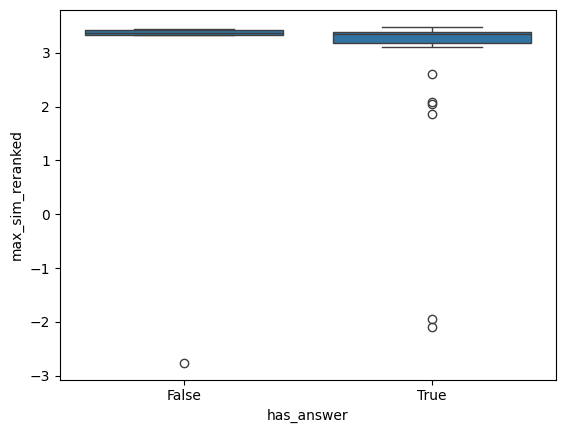

In [533]:
sns.boxplot(eval_df[eval_df["question_number"].isin(test_q["question_number"])], x="has_answer", y="max_sim_reranked")

Creating dataset for evaluation on answer level

In [536]:
reranked_answer_eval_df = pd.DataFrame([(q,v[0], v[1]) for q, answers in reranked_results.items() for v in answers], columns=["question_number", "answer", "similarity"])

In [537]:
reranked_answer_eval_df = pd.merge(reranked_answer_eval_df,ayatec[["question_number", "has_answer"]].drop_duplicates(), on=["question_number"], how="left")

In [538]:
reranked_answer_eval_df = pd.merge(reranked_answer_eval_df,ayatec[["question_number", "answer", "has_answer"]].rename({"has_answer": "correct_answer"},axis=1), on=["question_number", "answer"], how="left").fillna(False)

/var/folders/79/cr55_gjn2234ndn3x_f5707r0000gn/T/ipykernel_14434/772650788.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  reranked_answer_eval_df = pd.merge(reranked_answer_eval_df,ayatec[["question_number", "answer", "has_answer"]].rename({"has_answer": "correct_answer"},axis=1), on=["question_number", "answer"], how="left").fillna(False)


In [539]:
reranked_answer_eval_df

,question_number,answer,similarity,has_answer,correct_answer
0,101,11:89-95,3.424417,True,False
1,101,11:89-95,3.424417,True,False
2,101,26:176-191,3.389142,True,True
3,101,9:69-70,3.386365,True,False
4,101,9:69-70,3.386365,True,False
...,...,...,...,...,...
2495,613,5:82-86,3.356817,True,False
2496,613,13:5-7,3.349428,True,True
2497,613,13:12-13,3.339346,True,True
2498,613,39:11-20,3.282948,True,False


In [540]:
reranked_answer_eval_df["group_sim_rank"] = reranked_answer_eval_df.groupby("question_number")["similarity"].rank(ascending=False, method="dense")

<Axes: xlabel='has_answer', ylabel='similarity'>

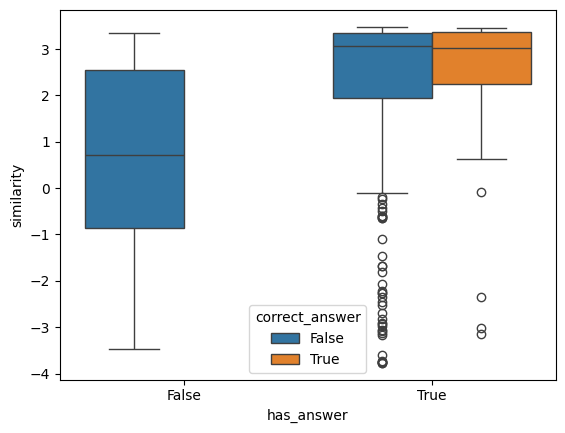

In [541]:
sns.boxplot(reranked_answer_eval_df[reranked_answer_eval_df["question_number"].isin(test_q["question_number"])], x="has_answer", y="similarity", hue="correct_answer")

In [261]:
reranked_answer_eval_df.loc[(reranked_answer_eval_df["question"].isin(test_questions)) & (reranked_answer_eval_df["group_sim_rank"] == 1), ["similarity"]].reset_index()

,index,similarity
0,90,2.459043
1,150,2.654969
2,151,2.654969
3,180,2.595760
4,181,2.595760
5,300,1.638308
6,450,2.669407
7,451,2.669407
8,600,2.430225
9,730,2.590621


<Axes: xlabel='similarity', ylabel='similarity'>

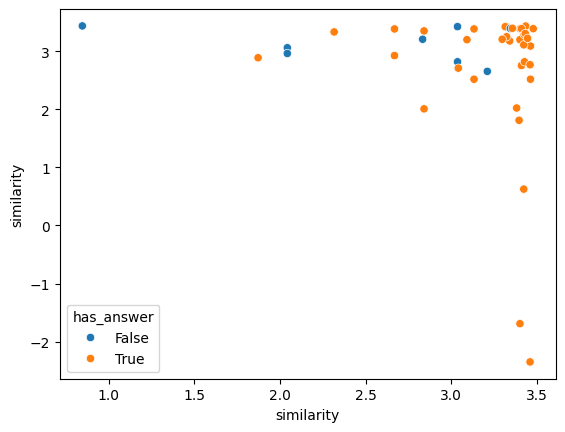

In [543]:
sns.scatterplot(x=reranked_answer_eval_df.loc[(reranked_answer_eval_df["question_number"].isin(test_q["question_number"])) & (reranked_answer_eval_df["group_sim_rank"] == 1), "similarity"].reset_index(drop=True),
y=reranked_answer_eval_df.loc[(reranked_answer_eval_df["question_number"].isin(test_q["question_number"])) & (reranked_answer_eval_df["group_sim_rank"] == 2), "similarity"].reset_index(drop=True),
hue=reranked_answer_eval_df.loc[(reranked_answer_eval_df["question_number"].isin(test_q["question_number"])) & (reranked_answer_eval_df["group_sim_rank"] == 1), "has_answer"].reset_index(drop=True))

In [249]:
reranked_answer_eval_df.loc[(reranked_answer_eval_df["group_sim_rank"] == 2) & (reranked_answer_eval_df["question"].isin(test_questions))]

,question,answer,similarity,has_answer,correct_answer,group_sim_rank
91,Who are the tribes (al‑Asbāṭ)?,4:90-91,2.178248,True,False,2.0
152,Which prophet was taught the language of birds...,21:78-82,2.641100,True,True,2.0
182,What is the waiting period (ʿiddah) for a divo...,2:228-230,2.578517,True,True,2.0
183,What is the waiting period (ʿiddah) for a divo...,2:228-230,2.578517,True,True,2.0
301,Who are the defrauders (Al‑Muṭaffifīn)?,83:1-6,1.147399,True,True,2.0
302,Who are the defrauders (Al‑Muṭaffifīn)?,83:1-6,1.147399,True,True,2.0
452,Who fashioned a calf from ornaments for the Ch...,7:154-156,2.591679,True,False,2.0
601,Did Prophet Moses live in Egypt?,43:46-56,2.410119,True,True,2.0
602,Did Prophet Moses live in Egypt?,43:46-56,2.410119,True,True,2.0
732,What happened to Prophet Yūnus after the whale...,21:87-88,2.507983,True,True,2.0


In [244]:
reranked_answer_eval_df.loc[(reranked_answer_eval_df["group_sim_rank"] == 1) & (reranked_answer_eval_df["question"].isin(test_questions))]

,question,answer,similarity,has_answer,correct_answer,group_sim_rank
90,Who are the tribes (al‑Asbāṭ)?,7:159-162,2.459043,True,True,1.0
150,Which prophet was taught the language of birds...,2:260-260,2.654969,True,False,1.0
151,Which prophet was taught the language of birds...,2:260-260,2.654969,True,False,1.0
180,What is the waiting period (ʿiddah) for a divo...,65:1-3,2.595760,True,False,1.0
181,What is the waiting period (ʿiddah) for a divo...,65:1-3,2.595760,True,False,1.0
300,Who are the defrauders (Al‑Muṭaffifīn)?,9:73-74,1.638308,True,False,1.0
450,Who fashioned a calf from ornaments for the Ch...,20:86-94,2.669407,True,True,1.0
451,Who fashioned a calf from ornaments for the Ch...,20:86-94,2.669407,True,True,1.0
600,Did Prophet Moses live in Egypt?,20:17-24,2.430225,True,False,1.0
730,What happened to Prophet Yūnus after the whale...,37:139-148,2.590621,True,True,1.0


In [ ]:
pd.pivot(data=reranked_answer_eval_df, index=["question", "group_sim_rank"], , values="similarity")

ValueError: The name group_sim_rank occurs multiple times, use a level number

In [ ]:
reranked_answer_eval_df.unstack( level="group_sim_rank", fill_value="similarity")

KeyError: 'Requested level (group_sim_rank) does not match index name (None)'

<Axes: xlabel='has_answer', ylabel='similarity'>

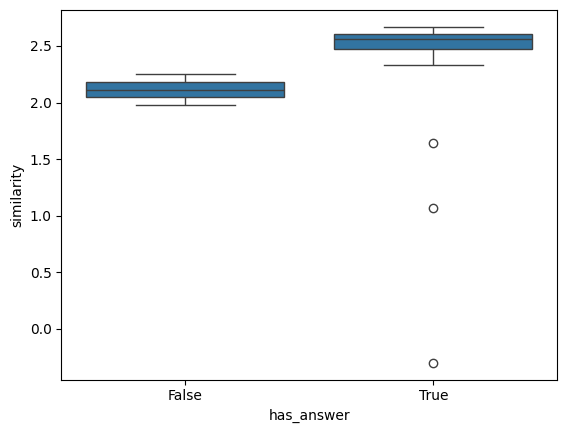

In [245]:
sns.boxplot(reranked_answer_eval_df.loc[(reranked_answer_eval_df["group_sim_rank"] == 1) & (reranked_answer_eval_df["question"].isin(test_questions))], x="has_answer", y="similarity")

## 7. No-Answer Detection


You can add a special `[NO_ANSWER]` label during fine-tuning or train a separate classifier on `(question, best_candidate)` pairs.


## 8. Answer Selection & Formatting

In [ ]:
def select_answer(question):
    cands = hybrid_retrieve(question)
    reranked = rerank(question, cands)
    best_pid, best_score = reranked[0]
    # TODO: apply no-answer threshold
    meta = qbc.set_index('passage_id').loc[best_pid, ['surah_number','ayah_start','ayah_end']]
    text = qbc.set_index('passage_id').loc[best_pid, 'text']
    return {
        'surah': int(meta['surah_number']),
        'ayah_start': int(meta['ayah_start']),
        'ayah_end': int(meta['ayah_end']),
        'text': text,
        'score': best_score
    }


## 9. Final Evaluation & Metrics

In [ ]:
def evaluate(test_questions):
    # test_questions: DataFrame with gold surah, ayah_start, ayah_end
    preds, golds = [], []
    for _, row in test_questions.iterrows():
        out = select_answer(row['question'])
        preds.append((out['surah'], out['ayah_start'], out['ayah_end']))
        golds.append((row['surah_number'], row['ayah_start'], row['ayah_end']))
    # Compute exact match
    em = np.mean([p==g for p,g in zip(preds,golds)])
    print(f"Exact Match: {em:.3f}")

# Run evaluation on our test set
# evaluate(test_q)


In [47]:
max_precision_at_k(gold_map, 5)

0.5733333333333339

## Load arabic data

### Subtask:
Load the `qbc_arab` DataFrame.


**Reasoning**:
The subtask is to load and explore the `qbc_arab` DataFrame. The DataFrame is already loaded, so I will display its head and columns to confirm its availability and contents.



In [16]:
display(qbc_arab.head())
print(qbc_arab.columns)

,passage,surah_number,ayah_start,ayah_end,aljalalyn_tafseer,almuyassar_tafseer
0,بسم الله الرحمن الرحيم. الحمد لله رب العالمين....,1,1,4,بسم الله الرحمن الرحيم الحمد لله جملة خبرية قص...,سورة الفاتحة سميت هذه السورة بالفاتحة؛ لأنه يف...
1,إياك نعبد وإياك نستعين. اهدنا الصراط المستقيم.,1,5,6,إيَّاك نعبد وإياك نستعين أي نخصك بالعبادة من ت...,إنا نخصك وحدك بالعبادة، ونستعين بك وحدك في جمي...
2,صراط الذين أنعمت عليهم غير المغضوب عليهم ولا ا...,1,7,7,صراط الَّذين أنعمت عليهم بالهداية ويبدل من الذ...,طريق الذين أنعمت عليهم من النبيين والصدِّيقين ...
3,الم. ذلك الكتاب لا ريب فيه هدى للمتقين.,2,1,2,الم الله أعلم بمراده بذلك. ذلك أي هذا الكتاب ا...,هذه الحروف وغيرها من الحروف المقطَّعة في أوائل...
4,الذين يؤمنون بالغيب ويقيمون الصلاة ومما رزقناه...,2,3,5,الذين يؤمنون يصدِّقون بالغيب بما غاب عنهم من ا...,وهم الذين يُصَدِّقون بالغيب الذي لا تدركه حواس...


Index(['passage', 'surah_number', 'ayah_start', 'ayah_end',
       'aljalalyn_tafseer', 'almuyassar_tafseer'],
      dtype='object')


## Choose arabic embedding model

### Subtask:
Select an appropriate pre-trained Arabic Sentence Transformer model (like one from the Arabert or Camel families).


## Encode arabic passages

### Subtask:
Use the chosen model to generate embeddings for the Arabic passages in `qbc_arab`.


**Reasoning**:
Generate embeddings for the Arabic passages using the chosen Sentence Transformer model.



In [72]:
def normalize_text_arabic(text):
    # Remove non-Arabic alphanumeric characters
    text = re.sub(r'[^\u0600-\u06FF0-9a-zA-Z\s]', '', text)
    return text

# Merge text fields
qbc_arab['text'] = qbc_arab['passage'] + "\n" + qbc_arab['aljalalyn_tafseer']
qbc_arab["text"] = qbc_arab["text"].fillna("")

# Create unique IDs
qbc_arab['passage_id'] = qbc_arab.apply(lambda r: f"{r.surah_number}:{r.ayah_start}-{r.ayah_end}", axis=1)

In [74]:
import os
import numpy as np

# Define the path to save/load embeddings
embeddings_path = "/content/drive/MyDrive/IslamicEval/Data/passage_embeddings_arab.npy"
faiss_index_path = "/content/drive/MyDrive/IslamicEval/Data/faiss_index_arab.faiss"

# 4.1 Encode passages
embed_model_arab = SentenceTransformer('FDSRashid/QulBERT')  # or other embedding

# Check if embeddings and index already exist
if os.path.exists(embeddings_path) and os.path.exists(faiss_index_path):
    print("Loading existing embeddings and FAISS index...")
    passage_embeddings_arab = np.load(embeddings_path)
    d = passage_embeddings_arab.shape[1]
    faiss_index = faiss.read_index(faiss_index_path)
else:
    print("Generating and saving embeddings and FAISS index...")
    passage_embeddings_arab = embed_model_arab.encode(qbc_arab["text"].tolist(), show_progress_bar=True)

    # Save embeddings
    np.save(embeddings_path, passage_embeddings_arab)
    print(f"Embeddings saved to {embeddings_path}")

    # 4.2 Build FAISS index
    d = passage_embeddings_arab.shape[1]
    faiss_index = faiss.IndexFlatIP(d)
    faiss.normalize_L2(passage_embeddings_arab)
    faiss_index.add(passage_embeddings_arab)

    # Save FAISS index
    faiss.write_index(faiss_index, faiss_index_path)
    print(f"FAISS index saved to {faiss_index_path}")

Batches:   0%|          | 0/40 [00:00<?, ?it/s]

In [75]:
# 4.3 Searching
def dense_search_arab(query, top_k=10):
    q_emb = embed_model_arab.encode([query])
    faiss.normalize_L2(q_emb)
    scores, idxs = faiss_index.search(q_emb, top_k)
    results = [(qbc_arab.iloc[i]['passage_id'], float(scores[0][j])) for j,i in enumerate(idxs[0])]
    return results

In [76]:
dense_search_arab("من هم قوم شعيب؟", top_k=10)

[('7:85-93', 0.6326546669006348),
 ('29:36-37', 0.5879510641098022),
 ('15:78-79', 0.5858718156814575),
 ('22:42-46', 0.5855753421783447),
 ('29:24-27', 0.5276505947113037),
 ('37:133-138', 0.5207889676094055),
 ('26:160-175', 0.5176262259483337),
 ('29:38-40', 0.5091129541397095),
 ('11:89-95', 0.49712374806404114),
 ('50:12-15', 0.4916177988052368)]

In [77]:
# Run retrieval per unique question
dense_results_arab = {q: dense_search_arab(q, 50) for q in gold_map_arab}

# Evaluate
print("Dense Recall@20:", recall_at_k(dense_results_arab, gold_map_arab, 50))
print("Dense Precision@10:", precision_at_k(dense_results_arab, gold_map_arab, 10))

Dense Recall@20: 0.42688056091948184
Dense Precision@10: 0.0857142857142857


Fusion with sparse

In [47]:
def SE_DA_hybrid_retrieve(query_e, query_a, k1=10, k2=10, final_k=20):
    sparse = tfidf_search(query_e, k1)
    dense = dense_search_arab(query_a, k2)
    # TODO: normalize scores and merge, then select top final_k
    # Simple placeholder: just concatenate for now
    all_cand = sparse + dense
    # TODO: implement proper fusion
    return all_cand[:final_k]

In [58]:
# Run retrieval per unique question
hyprid_results_arab = {q_e: SE_DA_hybrid_retrieve(q_e, q_a, k1=50, k2=50, final_k=100) for q_e, q_a in zip(gold_map, gold_map_arab)}

# Evaluate
print("hyprid Recall@20:", recall_at_k(hyprid_results_arab, gold_map, 100))
print("hyprid Precision@10:", precision_at_k(hyprid_results_arab, gold_map, 10))

hyprid Recall@20: 0.5758144852972363
hyprid Precision@10: 0.08142857142857142


In [ ]:
# Example usage with your sparse results:
# print("TF-IDF Precision@10:", precision_at_k(sparse_results, gold_map, 10))

# Example usage with your dense results:
# print("Dense Precision@10:", precision_at_k(dense_results, gold_map, 10))

# Example usage with your hybrid results:
# print("Hybrid Precision@10:", precision_at_k(hyprid_results, gold_map, 10))

# Example usage with your reranked results:
# print("Reranked Precision@10:", precision_at_k(reranked_results, gold_map, 10))

In [ ]:
!pip install numpy==1.26.4

# Note: After running this cell, you need to restart your Colab runtime
# (Runtime -> Restart runtime) and then re-run all cells from the beginning.